
**PROJET MIT BIH :**

        *   RUAN Jiek
        *   TIBOUCHE Tanya
        *   ELIDRISSI Yasmine
        *   LE DEZ Guillaume
        *   ALKARDO Ibrahim
            

**Importation des bibliotheques nécessaires**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import os
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Recall
import keras.optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Input, MultiHeadAttention, Dropout, LayerNormalization, Flatten
from tensorflow.keras.models import Model
import tensorflow.keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

from tensorflow.keras.layers import Input, LSTM, Dense, Permute, Multiply, Softmax, Lambda, Concatenate
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, GRU, Dense, Softmax, Multiply, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

**Connexion DRIVE**


In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


**Connexion au répertoire**

In [3]:
data_path = "/content/drive/MyDrive/DIA3 2024-2025/Réseau de neurones/project_mit_bih"
os.chdir(data_path)
#!ls "/content/drive/MyDrive/DIA3 2024-2025/Réseau de neurones"

**Lecture du jeu de données :**

  >Charge et nettoie le dataset MIT-BIH en remplissant les valeurs manquantes et en convertissant les labels au format entier.

In [4]:
def read_dataset(mit_bih_csv_path):
	df = pd.read_csv(mit_bih_csv_path)
	df.iloc[:, 187] = df.iloc[:, 187].fillna(0).astype('int64')
	return df

**Préparation des données ECG depuis un fichier Arduino :**

>   Charge et normalise les données ECG d'Arduino, puis extrait un battement unique avec un remplissage de zéros.




In [5]:
def read_arduino_ecg_data(arduino_ecg_csv_path):
	ecg = pd.read_csv(arduino_ecg_csv_path)['ECG Value'].values
	ecg = (ecg - np.mean(ecg)) / np.std(ecg)
	one_beat = np.concatenate((ecg[180: 270], np.zeros(97)))
	return one_beat

**Visualisation de la distribution des labels d'arythmie :**


> Affiche un graphique en secteurs pour visualiser la répartition des différentes classes d'arythmie dans les données.


In [6]:
def show_labels_distribution(mit_bih_df):
	# Afficher la distribution des labels dans la colonne 187
	distribution = mit_bih_df.iloc[:, 187].value_counts()


	plt.figure(figsize=(15, 6))
	wedges, texts, autotexts = plt.pie(distribution, autopct='%1.1f%%', startangle=90, labels=None)
	plt.title("Distribution des labels d'arythmie")
	plt.ylabel('')  # Pour ne pas afficher "187" comme étiquette de l'axe y
	plt.legend(
	    wedges,
			[label_mapping[idx] for idx in distribution.index],
	    title="Categories",
	    loc="center left",
	    bbox_to_anchor=(1, 0, 0.5, 1)  # Positionnement de la légende
	)
	plt.show()
	# Afficher le résultat
	print(distribution)
	return None


**Génération des valeurs X (ECG) et Y (labels) :**


> Sépare les données en signaux ECG (X) et leurs labels correspondants (Y) sous forme de tableaux NumPy.




In [7]:
def generate_x_y_values(mit_bih_df):
	ecgs, arythmies_labels = [], []
	for _, row in tqdm.tqdm(mit_bih_df.iterrows(), total=len(mit_bih_df)):
		ecgs.append(row.iloc[0 : 187])
		arythmies_labels.append(int(row.iloc[187]))

	return np.array(ecgs), np.array(arythmies_labels)


**Génération des valeurs X (ECG) et Y (labels) en utilisant 2 classes seulements :**


> Sépare les données en signaux ECG (X) et leurs labels correspondants (Y) sous forme de tableaux NumPy.




In [ ]:
def generate_x_y_values_with_2_classes(mit_bih_df):
  ecgs, arythmies_labels = [], []
  for _, row in tqdm.tqdm(mit_bih_df.iterrows(), total=len(mit_bih_df)):
    ecgs.append(row.iloc[0 : 187].values)
    if int(row.iloc[187]) == 0:
      arythmies_labels.append(0)
    else:
      arythmies_labels.append(1)

  return np.array(ecgs), np.array(arythmies_labels)

**Comptage des échantillons par classe :**

> Compte et affiche le nombre d'échantillons disponibles pour chaque classe dans le dataset.
> Regrouper les classes de 1 à 4 en une classe malade qui est égale à 1




In [8]:
mit_bih_csv_path="./mitbih_train.csv"
mit_bih_df = read_dataset(mit_bih_csv_path)


mit_bih_csv_path_test="./mitbih_test.csv"
mit_bih_df_test = read_dataset(mit_bih_csv_path_test)


random_seed = 42

mit_bih_df = mit_bih_df.sample(frac=1, random_state=random_seed).reset_index(drop=True)
mit_bih_df_test = mit_bih_df_test.sample(frac=1, random_state=random_seed).reset_index(drop=True)

#mit_bih_df.replace({2: 1, 3: 1, 4: 1}, inplace=True) Pour regrouper les classes dans le cas ou nous souhaitons faire que deux classes
#mit_bih_df_test.replace({2: 1, 3: 1, 4: 1}, inplace=True)


**Équilibrage des classes avec du bruit gaussien :**


> Équilibre les classes du dataset en ajoutant du bruit gaussien aux classes sous-représentées.



In [9]:
def count_rows_by_class(mit_bih_df):
    class_counts = mit_bih_df.iloc[:, -1].value_counts()

    print("Nombre de lignes par classe :")
    print(class_counts)

    return class_counts
count_rows_by_class(mit_bih_df)

def balance_classes_with_gaussian_noise(df, target_column):
    classes = df[target_column].unique()
    max_class_count = df[target_column].value_counts().max()

    balanced_data = []

    for class_label in classes:
        class_data = df[df[target_column] == class_label]
        class_count = len(class_data)

        if class_count == max_class_count:
            balanced_data.append(class_data)
        else:
            rows_to_add = max_class_count - class_count

            sampled_data = class_data.sample(n=rows_to_add, replace=True, random_state=42)

            signal_columns = df.columns[:-1]
            noise = np.random.normal(0, 0.01, size=(rows_to_add, len(signal_columns)))  # Bruit gaussien
            noisy_data = sampled_data.copy()
            noisy_data[signal_columns] += noise

            balanced_data.append(pd.concat([class_data, noisy_data]))

    balanced_df = pd.concat(balanced_data).reset_index(drop=True)
    return balanced_df


target_column = mit_bih_df.columns[-1]
target_column2 = mit_bih_df_test.columns[-1]

mit_bih_df = balance_classes_with_gaussian_noise(mit_bih_df, target_column)
mit_bih_df_test = balance_classes_with_gaussian_noise(mit_bih_df_test, target_column2)

print(mit_bih_df[target_column].value_counts())



Nombre de lignes par classe :
0.000000000000000000e+00.88
0.0    72470
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64
0.000000000000000000e+00.88
0.0    72470
4.0    72470
1.0    72470
2.0    72470
3.0    72470
Name: count, dtype: int64


**Enlever les valeurs nul à la fin de chaque signal:**

> Utiliser des tensorflow ragged pour stocker les signaux sans les zéros



In [ ]:
import tensorflow as tf
import numpy as np

def remove_trailing_zeros_ragged(ecg_data):
    """
    Convertit les signaux ECG en RaggedTensor, en supprimant les zéros en fin de séquence.

    Arguments :
    - ecg_data : DataFrame contenant les signaux ECG (chaque ligne est un signal).

    Retour :
    - RaggedTensor représentant les signaux nettoyés.
    """
  ecg_array = ecg_data.iloc[:, :-1].to_numpy()

    cleaned_signals = []

    for signal in ecg_array:
        non_zero_indices = np.where(signal != 0)[0]
        if len(non_zero_indices) > 0:
            last_non_zero_index = non_zero_indices[-1]
            cleaned_signals.append(signal[:last_non_zero_index + 1])
        else:
            cleaned_signals.append([])

    ragged_tensor = tf.ragged.constant(cleaned_signals)
    return ragged_tensor



mit_bih_df=remove_trailing_zeros_ragged(mit_bih_df)

print("Exemple de RaggedTensor :"
print(mit_bih_df)


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 14)

**Afficher un signal avant et après avoir enlever les zéros**

In [ ]:
import matplotlib.pyplot as plt

def plot_ragged_tensor(ragged_tensor, original_data, sample_index):
    original_signal = original_data.iloc[sample_index, :-1].values

    cleaned_signal = ragged_tensor[sample_index].numpy()

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(original_signal, label="")
    plt.title("")
    plt.xlabel("samples")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(cleaned_signal, color='orange')
    plt.title("")
    plt.xlabel("samples")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)

    plt.suptitle("ECG Signal Comparison", fontsize=16)
    plt.tight_layout()
    plt.show()

sample_index = 0  # Modifier l'index pour tester différents signaux
plot_ragged_tensor(ragged_ecg, mit_bih_df, sample_index)


AttributeError: 'RaggedTensor' object has no attribute 'iloc'

**Préparation des données pour l'entraînement :**


> Transforme et normalise les données en entrées pour les modèles d'apprentissage automatique.



In [10]:
#ecgs, arythmies_labels = generate_x_y_values_with_2_classes(mit_bih_df) dans le cas ou nous souhaitons faire deux classes
#ecgs_test, arythmies_labels_test = generate_x_y_values_with_2_classes(mit_bih_df_test)

ecgs, arythmies_labels = generate_x_y_values(mit_bih_df)
ecgs_test, arythmies_labels_test = generate_x_y_values(mit_bih_df_test)



100%|██████████| 90585/90585 [00:07<00:00, 11918.54it/s]


In [11]:
X_train = ecgs
y_train = arythmies_labels

X_test = ecgs_test
y_test = arythmies_labels_test



min_samples = min(len(X_train), len(y_train))
X_train = X_train[:min_samples]
y_train = y_train[:min_samples]

min_samples = min(len(X_test), len(y_test))
X_test = X_test[:min_samples]
y_test = y_test[:min_samples]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))



**Construction et entraînement du modèle LSTM :**


> Modèle LSTM pour classer les arythmies à partir des données ECG, basé sur une architecture séquentielle.





In [ ]:
#LSTM
model = Sequential(
    [
        LSTM(100, activation="tanh", recurrent_activation="sigmoid"),  # Encodeur
        Dense(5, activation="softmax")  # Classifieur
    ]
)


**Construction et entraînement du modèle GRU :**

> Modèle GRU (Gated Recurrent Unit) pour classer les arythmies, optimisé pour capturer les séquences temporelles.



In [ ]:
#GRU
model = Sequential(
    [
        GRU(100, activation="tanh", recurrent_activation="sigmoid", input_shape=(X_train_scaled.shape[1], 1)),
        Dense(5, activation="softmax")  # Classifieur
    ]
)



**Compilation du modèle avec l'optimiseur Adam et la fonction de perte catégorielle:**


> Cette ligne configure le modèle pour l'entraînement avec un optimiseur Adam, une perte catégorielle sparse, et la métrique de précision.



In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

**Résumé de l'architecture du modèle:**

> Affiche un aperçu détaillé des couches, du nombre de paramètres, et de la structure du modèle.




In [ ]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             505 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 123,917 (484.05 KB)

 Trainable params: 41,305 (161.35 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 82,612 (322.71 KB)

**Entraînement du modèle avec EarlyStopping:**

> Lance l'entraînement du modèle avec arrêt anticipé lorsque la perte ne s'améliore plus après un certain nombre d'époques.



In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='loss',patience=3)
history=model.fit(
    X_train_scaled, y_train,
validation_split=0.15,    epochs=30,
    batch_size=128,
    verbose=2,callbacks=[callback]

)
len(history.history['loss'])

Epoch 1/30
2407/2407 - 32s - 13ms/step - accuracy: 0.7632 - loss: 0.5902 - val_accuracy: 1.0000 - val_loss: 0.3610
Epoch 2/30
2407/2407 - 27s - 11ms/step - accuracy: 0.7890 - loss: 0.4570 - val_accuracy: 0.8689 - val_loss: 0.4137
Epoch 3/30
2407/2407 - 41s - 17ms/step - accuracy: 0.8011 - loss: 0.4195 - val_accuracy: 0.9228 - val_loss: 0.4140
Epoch 4/30
2407/2407 - 42s - 17ms/step - accuracy: 0.8572 - loss: 0.3323 - val_accuracy: 0.9666 - val_loss: 0.2046
Epoch 5/30
2407/2407 - 40s - 17ms/step - accuracy: 0.8768 - loss: 0.2940 - val_accuracy: 0.9303 - val_loss: 0.2156
Epoch 6/30
2407/2407 - 42s - 17ms/step - accuracy: 0.8887 - loss: 0.2730 - val_accuracy: 0.9252 - val_loss: 0.1984
Epoch 7/30
2407/2407 - 41s - 17ms/step - accuracy: 0.8981 - loss: 0.2565 - val_accuracy: 0.9395 - val_loss: 0.1704
Epoch 8/30
2407/2407 - 41s - 17ms/step - accuracy: 0.9038 - loss: 0.2415 - val_accuracy: 0.9280 - val_loss: 0.1849
Epoch 9/30
2407/2407 - 41s - 17ms/step - accuracy: 0.9084 - loss: 0.2283 - val_a

30

**Entraînement du modèle avec EarlyStopping et décroissance exponentielle du taux d'apprentissage:**


> Entraîne le modèle en combinant EarlyStopping et une stratégie de réduction exponentielle du taux d'apprentissage.



In [ ]:


lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=False
)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])


callback = keras.callbacks.EarlyStopping(monitor='loss',patience=3)
history=model.fit(
    X_train_scaled, y_train,
validation_split=0.15,    epochs=1000,
    batch_size=256,
    verbose=2,callbacks=[callback]

)
len(history.history['loss'])

**Entraînement du modèle avec ReduceLROnPlateau et EarlyStopping :**


> Combine les callbacks ReduceLROnPlateau et EarlyStopping pour optimiser le processus d'entraînement en ajustant le taux d'apprentissage et en arrêtant l'entraînement prématurément si nécessaire.



In [ ]:


reduce_lr = ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.15,
    epochs=1000,
    batch_size=256,
    verbose=2,
    callbacks=[callback, reduce_lr]
)


**Construction et entraînement d'un modèle Transformers :**


> Implémentation d'un modèle Transformer avec couches MultiHeadAttention pour classer les arythmies à partir des signaux ECG.
>l'output et le modele en commentaire sont pour le cas ou on regroupe les données en deux classes au lieu de 5
>Vue que la classification est binaire on a choisis sigmoid & Binary Crossentropy and Accuracy



In [12]:

input_shape = X_train_scaled.shape[1:]
num_heads = 4
embed_dim = 64
ff_dim = 128
dropout_rate = 0.1

def transformer_encoder(inputs, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(inputs + attention_output)

    ffn_output = Dense(ff_dim, activation="relu")(attention_output)
    ffn_output = Dense(embed_dim)(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    return LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)

inputs = Input(shape=input_shape)
x = Dense(embed_dim)(inputs)
x = transformer_encoder(x, embed_dim, num_heads, ff_dim, dropout_rate)
x = transformer_encoder(x, embed_dim, num_heads, ff_dim, dropout_rate)

x = Flatten()(x)
outputs = Dense(5, activation="softmax")(x)
#outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
#model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

history = model.fit(
    X_train_scaled,
    y_train,
    epochs=200,
    batch_size=128,
    validation_data=(X_test_scaled, y_test),
    #class_weight={0: 1., 1: 2., 2: 1., 3: 1., 4: 1.},
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/200
2831/2831 ━━━━━━━━━━━━━━━━━━━━ 131s 42ms/step - accuracy: 0.8511 - loss: 0.4381 - val_accuracy: 0.9262 - val_loss: 0.2373 - learning_rate: 1.0000e-04
Epoch 2/200
2831/2831 ━━━━━━━━━━━━━━━━━━━━ 133s 41ms/step - accuracy: 0.9504 - loss: 0.1501 - val_accuracy: 0.9444 - val_loss: 0.2090 - learning_rate: 1.0000e-04
Epoch 3/200
2831/2831 ━━━━━━━━━━━━━━━━━━━━ 140s 41ms/step - accuracy: 0.9674 - loss: 0.1029 - val_accuracy: 0.9504 - val_loss: 0.2184 - learning_rate: 1.0000e-04
Epoch 4/200
2831/2831 ━━━━━━━━━━━━━━━━━━━━ 142s 41ms/step - accuracy: 0.9754 - loss: 0.0794 - val_accuracy: 0.9470 - val_loss: 0.2453 - learning_rate: 1.0000e-04
Epoch 5/200
2831/2831 ━━━━━━━━━━━━━━━━━━━━ 142s 41ms/step - accuracy: 0.9806 - loss: 0.0644 - val_accuracy: 0.9493 - val_loss: 0.2506 - learning_rate: 1.0000e-04
Epoch 6/200
2831/2831 ━━━━━━━━━━━━━━━━━━━━ 142s 41ms/step - accuracy: 0.9824 - loss: 0.0569 - val_accuracy: 0.9477 - val_loss: 0.2526 - learning_rate: 1.0000e-04
Epoch 7/200
2831/2831 ━━━━━━

**Enregistrer le résultat du modèle dans une variable**

In [ ]:
trained_model = model

training_history = history.history

print(training_history["accuracy"])
print(training_history["val_loss"])


[0.9044073224067688, 0.957955002784729, 0.9716379046440125, 0.9774969220161438, 0.9811646342277527, 0.983565628528595, 0.9853649735450745, 0.9867613911628723, 0.9901145100593567, 0.9903435707092285, 0.9908817410469055, 0.9912763833999634, 0.9915854930877686]
[0.23901508748531342, 0.2311651110649109, 0.22914206981658936, 0.25122570991516113, 0.2854610085487366, 0.2665979862213135, 0.28760817646980286, 0.2783921957015991, 0.28925803303718567, 0.28928086161613464, 0.28782323002815247, 0.2841006815433502, 0.29004424810409546]


**Courbe ROC**


> Cette fonction nous permet de crée la courbe ROC



2831/2831 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step


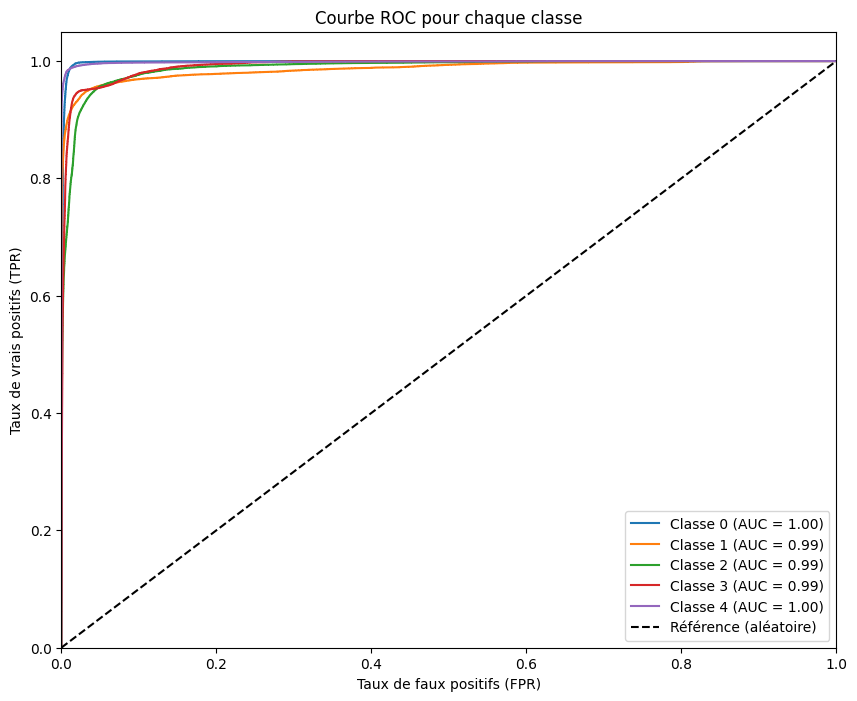

In [13]:


def plot_roc_curve(model, X_test, y_test, n_classes):

    y_pred_proba = model.predict(X_test)


    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Référence (aléatoire)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de faux positifs (FPR)')
    plt.ylabel('Taux de vrais positifs (TPR)')
    plt.title('Courbe ROC pour chaque classe')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(model, X_test_scaled, y_test, n_classes=5)


**Évaluation des performances du modèle avec les métriques et la matrice de confusion:**



> Ce bloc évalue la précision du modèle sur les données de test, génère un rapport détaillé des classes, et affiche une matrice de confusion.

> Ici on a le code pour la Matrice de confusion pour les 5 classes, et également le code pour regrouper les classes en deux catégories sains et malade et cela d'une manière équitable

2831/2831 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
Accuracy sur le dataset de test : 0.9444

Rapport détaillé :
              precision    recall  f1-score   support

    Classe 0       0.96      0.98      0.97     18117
    Classe 1       0.95      0.91      0.93     18117
    Classe 2       0.89      0.92      0.91     18117
    Classe 3       0.94      0.93      0.94     18117
    Classe 4       0.98      0.97      0.98     18117

    accuracy                           0.94     90585
   macro avg       0.94      0.94      0.94     90585
weighted avg       0.94      0.94      0.94     90585



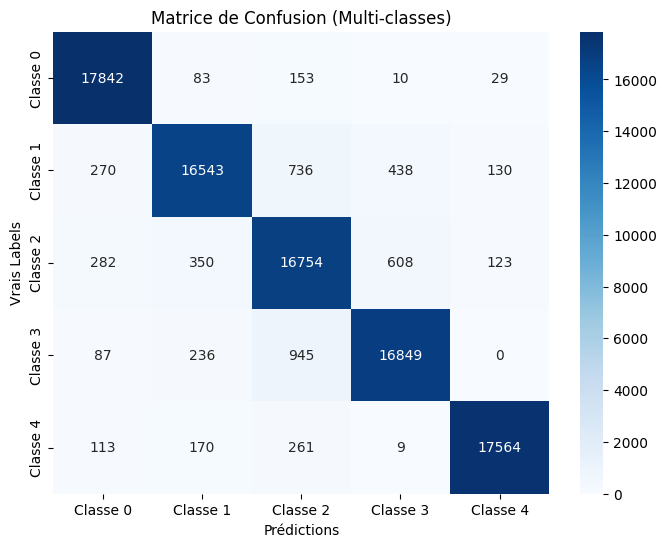

In [20]:

y_pred = np.argmax(model.predict(X_test_scaled), axis=-1)

accuracy_test = accuracy_score(y_test, y_pred)
print(f"Accuracy sur le dataset de test : {accuracy_test:.4f}")

print("\nRapport détaillé :")
print(classification_report(
    y_test,
    y_pred,
    target_names=['Classe 0', 'Classe 1', 'Classe 2', 'Classe 3', 'Classe 4']
))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=['Classe 0', 'Classe 1', 'Classe 2', 'Classe 3', 'Classe 4'],
    yticklabels=['Classe 0', 'Classe 1', 'Classe 2', 'Classe 3', 'Classe 4']
)
plt.xlabel('Prédictions')
plt.ylabel('Vrais Labels')
plt.title('Matrice de Confusion (Multi-classes)')
plt.show()


2831/2831 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
Accuracy sur le dataset de test : 0.9887

Rapport détaillé :
              precision    recall  f1-score   support

        Bien       0.96      0.98      0.97     18117
      Malade       1.00      0.99      0.99     72468

    accuracy                           0.99     90585
   macro avg       0.98      0.99      0.98     90585
weighted avg       0.99      0.99      0.99     90585



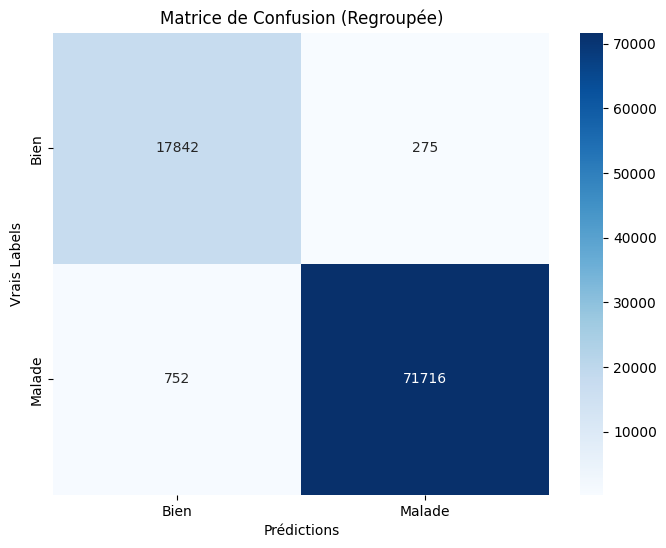

In [21]:


map_to_two_classes = {
    0: 0,
    1: 1,
    2: 1,
    3: 1,
    4: 1
}

data = list(zip(X_train_scaled, y_train))
class_0 = [d for d in data if d[1] == 0]
class_1 = [d for d in data if d[1] == 1]
class_2 = [d for d in data if d[1] == 2]
class_3 = [d for d in data if d[1] == 3]
class_4 = [d for d in data if d[1] == 4]

target_size = len(class_0)

class_1_sample = resample(class_1, replace=False, n_samples=target_size // 4, random_state=42)
class_2_sample = resample(class_2, replace=False, n_samples=target_size // 4, random_state=42)
class_3_sample = resample(class_3, replace=False, n_samples=target_size // 4, random_state=42)
class_4_sample = resample(class_4, replace=False, n_samples=target_size // 4, random_state=42)

new_class_1 = class_1_sample + class_2_sample + class_3_sample + class_4_sample

balanced_data = class_0 + new_class_1

np.random.shuffle(balanced_data)

X_balanced = np.array([d[0] for d in balanced_data])
y_balanced = np.array([map_to_two_classes[d[1]] for d in balanced_data])

y_pred = np.argmax(model.predict(X_test_scaled), axis=-1)

y_test_mapped = np.array([map_to_two_classes[label] for label in y_test])
y_pred_mapped = np.array([map_to_two_classes[label] for label in y_pred])

accuracy_test = accuracy_score(y_test_mapped, y_pred_mapped)
print(f"Accuracy sur le dataset de test : {accuracy_test:.4f}")

print("\nRapport détaillé :")
print(classification_report(
    y_test_mapped,
    y_pred_mapped,
    target_names=['Bien', 'Malade']
))

cm = confusion_matrix(y_test_mapped, y_pred_mapped)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=['Bien', 'Malade'],
    yticklabels=['Bien', 'Malade']
)
plt.xlabel('Prédictions')
plt.ylabel('Vrais Labels')
plt.title('Matrice de Confusion (Regroupée)')
plt.show()


**Construction et entraînement du modèle LSTM + Attetion:**


> Modèle LSTM pour classer les arythmies à partir des données ECG, basé sur une architecture séquentielle.





In [ ]:

input_layer = Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]))

lstm_out, state_h, state_c = LSTM(100, return_sequences=True, return_state=True)(input_layer)

attention = Dense(1, activation="tanh")(lstm_out)  # Calcule un score pour chaque pas de temps
attention = Softmax(axis=1)(attention)            # Normalise les scores en probabilités
context_vector = Multiply()([lstm_out, attention])  # Applique les poids aux sorties du LSTM
context_vector = Lambda(lambda x: K.sum(x, axis=1))(context_vector)  # Somme pondérée des pas de temps

output_layer = Dense(5, activation="softmax")(context_vector)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

callback = keras.callbacks.EarlyStopping(monitor="loss", patience=3)
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.15,
    epochs=30,
    batch_size=128,
    verbose=2,
    callbacks=[callback],
)


len(history.history["loss"])


Epoch 1/30
2407/2407 - 36s - 15ms/step - accuracy: 0.7817 - loss: 0.5232 - val_accuracy: 0.9479 - val_loss: 0.4018
Epoch 2/30
2407/2407 - 39s - 16ms/step - accuracy: 0.7949 - loss: 0.4548 - val_accuracy: 0.9536 - val_loss: 0.4779
Epoch 3/30
2407/2407 - 41s - 17ms/step - accuracy: 0.8132 - loss: 0.3879 - val_accuracy: 0.7261 - val_loss: 0.4167
Epoch 4/30
2407/2407 - 42s - 17ms/step - accuracy: 0.8533 - loss: 0.2994 - val_accuracy: 0.8155 - val_loss: 0.3427
Epoch 5/30
2407/2407 - 40s - 17ms/step - accuracy: 0.8872 - loss: 0.2500 - val_accuracy: 0.8893 - val_loss: 0.1963
Epoch 6/30
2407/2407 - 41s - 17ms/step - accuracy: 0.9059 - loss: 0.2207 - val_accuracy: 0.8997 - val_loss: 0.2021
Epoch 7/30
2407/2407 - 32s - 13ms/step - accuracy: 0.9146 - loss: 0.2039 - val_accuracy: 0.9337 - val_loss: 0.1825
Epoch 8/30
2407/2407 - 32s - 13ms/step - accuracy: 0.9217 - loss: 0.1909 - val_accuracy: 0.9138 - val_loss: 0.2065
Epoch 9/30
2407/2407 - 32s - 13ms/step - accuracy: 0.9208 - loss: 0.1939 - val_a

30

**Construction et entraînement du modèle GRU + Attetion:**


> Modèle GRU pour classer les arythmies à partir des données ECG, basé sur une architecture séquentielle.





In [ ]:



input_layer = Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]))


gru_out = GRU(100, return_sequences=True)(input_layer)


attention = Dense(1, activation="tanh")(gru_out)  # Scores d'attention
attention = Softmax(axis=1)(attention)           # Normalisation des scores
context_vector = Multiply()([gru_out, attention])  # Appliquer les poids
context_vector = Lambda(lambda x: K.sum(x, axis=1))(context_vector)  # Somme pondérée sur les pas de temps


output_layer = Dense(5, activation="softmax")(context_vector)


model = Model(inputs=input_layer, outputs=output_layer)


model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])


callback = keras.callbacks.EarlyStopping(monitor="loss", patience=3)
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.15,
    epochs=30,
    batch_size=128,
    verbose=2,
    callbacks=[callback],
)

len(history.history["loss"])


Epoch 1/30
2407/2407 - 35s - 14ms/step - accuracy: 0.7678 - loss: 0.5459 - val_accuracy: 0.9316 - val_loss: 0.3941
Epoch 2/30
2407/2407 - 41s - 17ms/step - accuracy: 0.7854 - loss: 0.4725 - val_accuracy: 0.8803 - val_loss: 0.4624
Epoch 3/30
2407/2407 - 40s - 17ms/step - accuracy: 0.7871 - loss: 0.4576 - val_accuracy: 0.7118 - val_loss: 0.5142
Epoch 4/30
2407/2407 - 41s - 17ms/step - accuracy: 0.8198 - loss: 0.3815 - val_accuracy: 0.9507 - val_loss: 0.2174
Epoch 5/30
2407/2407 - 41s - 17ms/step - accuracy: 0.8599 - loss: 0.3102 - val_accuracy: 0.9626 - val_loss: 0.2117
Epoch 6/30
2407/2407 - 40s - 17ms/step - accuracy: 0.8706 - loss: 0.2922 - val_accuracy: 0.9250 - val_loss: 0.2778
Epoch 7/30
2407/2407 - 41s - 17ms/step - accuracy: 0.8798 - loss: 0.2800 - val_accuracy: 0.9555 - val_loss: 0.2334
Epoch 8/30
2407/2407 - 30s - 12ms/step - accuracy: 0.8886 - loss: 0.2693 - val_accuracy: 0.9471 - val_loss: 0.2511
Epoch 9/30
2407/2407 - 30s - 13ms/step - accuracy: 0.8942 - loss: 0.2604 - val_a

30